In [10]:
import pandas as pd
import os
import sys
import numpy as np
from matplotlib import pyplot as plt

sys.path.append("..")
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import rbf_functions

rbfs = [
    rbf_functions.original_rbf,
    rbf_functions.squared_exponential_rbf,
    rbf_functions.inverse_quadratic_rbf,
    rbf_functions.inverse_multiquadric_rbf,
    rbf_functions.exponential_rbf,
    rbf_functions.matern32_rbf,
    rbf_functions.matern52_rbf,
]

def format_rbf_name(name):
    # Convert underscores to spaces and capitalize the first letter of each word
    formatted_name = ' '.join(word.capitalize() for word in name.split('_'))

    # Convert "Rbf" to "RBF"
    formatted_name = formatted_name.replace("Rbf", "")
    formatted_name = formatted_name.replace("Original", "Modified SE")

    # Convert "Matern32" to "Matern 32" and "Matern52" to "Matern 52"
    formatted_name = formatted_name.replace("Matern32", "Matern 32")
    formatted_name = formatted_name.replace("Matern52", "Matern 52")

    return formatted_name

In [12]:
# sns.set(rc={"figure.figsize": (11.7, 8.27)})
sns.set_style("white")

In [13]:
pd.read_csv("./calculated_metrics/hv_refset_global.csv").iloc[0, -1]

0.021748947298684

/var/folders/fg/q50zvs055fg3jrm35194kn5dsywm3z/T/ipykernel_29248/1668846940.py:82: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


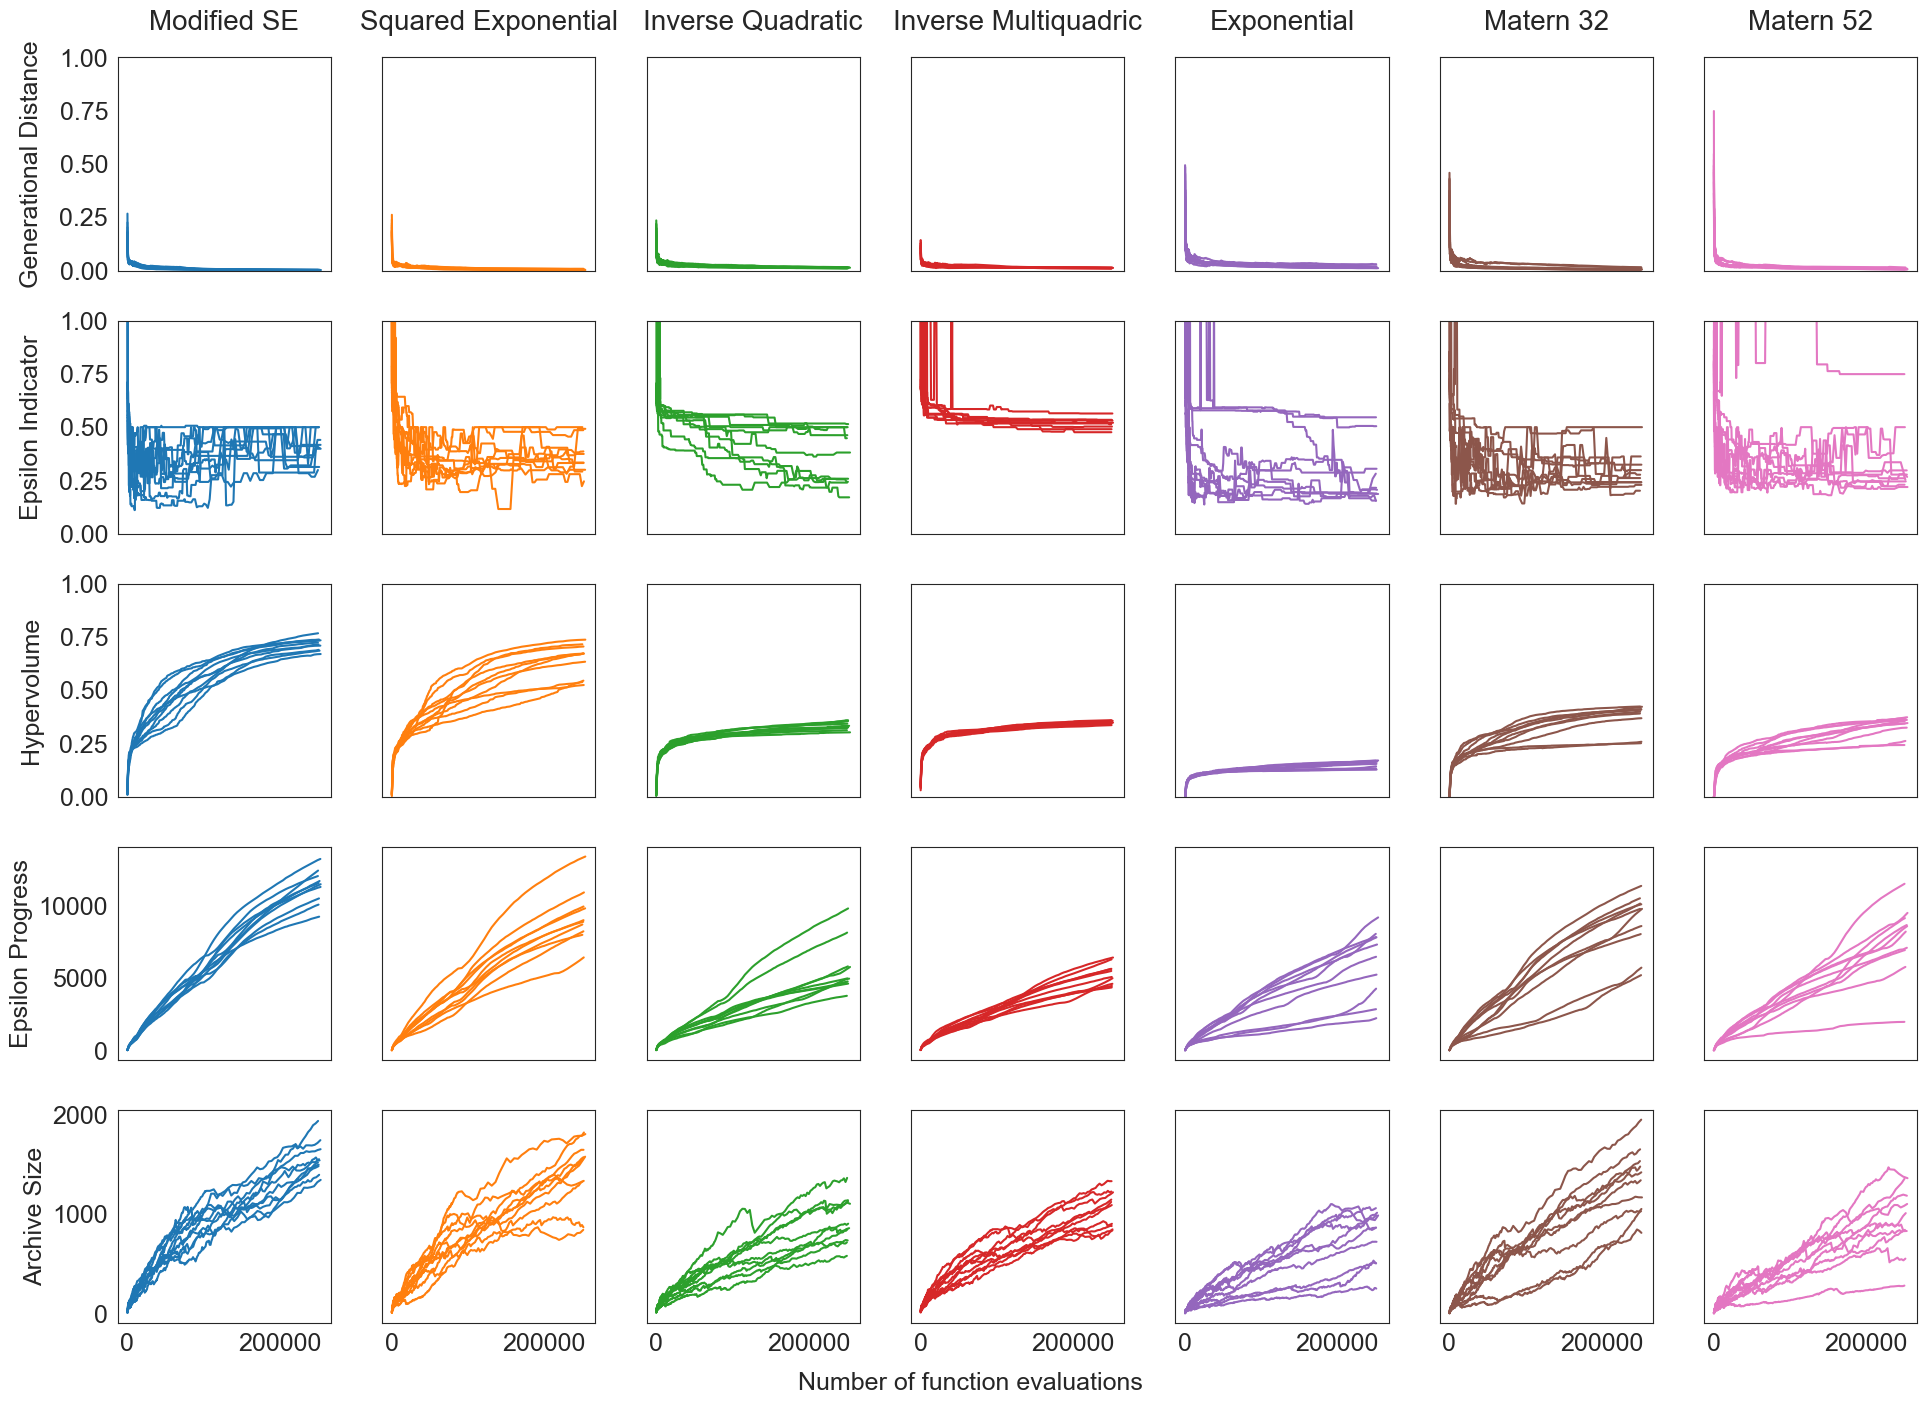

In [18]:
fig, axes = plt.subplots(5, 7, sharex=True, sharey="row", figsize=(20, 14))  #

fontsize = 18
plt.rcParams.update({
    'font.size': fontsize,               # Default fontsize for text added to plots (xlabel, ylabel, title, etc.)
    'axes.labelsize': fontsize,          # Fontsize of the x and y labels
    'xtick.labelsize': fontsize,         # Fontsize of the tick labels
    'ytick.labelsize': fontsize,         # Fontsize of the tick labels
    'legend.fontsize': fontsize,         # Fontsize in the legend
    'axes.titlesize': 20          # Fontsize of subplot titles
})
lw = 1.5

# for i, entry in enumerate(rbfs):
for i, (entry, c) in enumerate(zip(rbfs, sns.color_palette())):
    rbf = entry.__name__
    df_hv = pd.read_csv(f"calculated_metrics/hv_{rbf}_global.csv")
    df_ei = pd.read_csv(f"calculated_metrics/ei_{rbf}_global.csv")
    df_gd = pd.read_csv(f"calculated_metrics/gd_{rbf}_global.csv")

    hv_global = pd.read_csv("./calculated_metrics/hv_refset_global.csv").iloc[0, -1]

    df_hv.hypervolume /= hv_global

    ep_nfe = {}
    ep_prog = {}
    archive_nfe = {}
    archive_count = {}
    out_dir = f"../output/{rbf}/"
    for j in os.listdir(out_dir):
        if j.endswith("_convergence.csv"):
            ep_load = pd.read_csv(out_dir + j)
            ep_nfe[int(j.split("_")[0])] = ep_load.nfe
            ep_prog[int(j.split("_")[0])] = ep_load.improvements
        if j.endswith("_hypervolume.csv"):
            archives_by_nfe = pd.read_csv(out_dir + j)
            dups = archives_by_nfe.pivot_table(columns=["Unnamed: 0"], aggfunc="size")
            archive_nfe[int(j.split("_")[0])] = dups.index
            archive_count[int(j.split("_")[0])] = dups.reset_index(drop=True)
    ep_nfe = pd.DataFrame.from_dict(ep_nfe)
    ep_prog = pd.DataFrame.from_dict(ep_prog)
    archive_nfe = pd.DataFrame.from_dict(archive_nfe, orient="index").T
    archive_size = pd.DataFrame.from_dict(archive_count, orient="index").T

    # ax[0,i].plot(df_gd_nfe, df_gd, color=c, lw=0.5)

    for _, entry in df_gd.groupby("seed"):
        axes[0, i].plot(entry.nfe, entry.gd, color=c, lw=lw)

    for _, entry in df_ei.groupby("seed"):
        axes[1, i].plot(entry.nfe, entry.ei, color=c, lw=lw)

    for _, entry in df_hv.groupby("seed"):
        axes[2, i].plot(entry.nfe, entry.hypervolume, color=c, lw=lw)

    axes[3, i].plot(ep_nfe, ep_prog, color=c, lw=lw)
    axes[4, i].plot(archive_nfe, archive_size, color=c, lw=lw)

    for ax in axes[:, i]:
        ax.set_box_aspect(1)

    if i == 0:
        axes[0, i].set_ylabel("Generational Distance", labelpad=12)
        axes[1, i].set_ylabel("Epsilon Indicator", labelpad=12)
        axes[2, i].set_ylabel("Hypervolume", labelpad=12)  # , rotation=45, labelpad=40
        axes[3, i].set_ylabel("Epsilon Progress", labelpad=4)
        axes[4, i].set_ylabel("Archive Size", labelpad=4)

        # for j in range(3):
        #     axes[j, i].set_ylim(ymin=0, ymax=1)

    # axes[4, i].set_xlabel("nfe")
    axes[0, i].set_title(rbf[:-4])
    axes[0, i].set_title(format_rbf_name(rbf[:-4]), y= 1.09)

for row in axes[0:3]:
    ax = row[0]
    ax.set_ylim(ymin=0, ymax=1)


fig.tight_layout()
fig.tight_layout()
fig.text(0.5, -0.0005, 'Number of function evaluations', ha='center', va='center', fontsize=fontsize)
plt.savefig("./figs/paper_figures/png/metrics_Susquehanna.png", bbox_inches='tight')
plt.savefig("./figs/paper_figures/pdf/metrics_Susquehanna.pdf", bbox_inches='tight')